In [68]:
import torch
import numpy as np
import os
import json
from types import SimpleNamespace

import sys
sys.path.insert(4,'STG_NF')

from STG_NF.models.STG_NF.model_pose import STG_NF
from STG_NF.utils.train_utils import init_model_params
from STG_NF.dataset import get_dataset_and_loader
from STG_NF.utils.data_utils import trans_list

from STG_NF_utils import save_predicted_scores_only

# for drawing video output
import cv2
from video_inference_utils import draw_keypoints

import matplotlib.pyplot as plt

In [2]:
# === Paths to model weights and input/output directories ===
ARGS_JSON_PATH = 'weights/STG_NF/args.json'
CHECKPOINT_PATH = 'weights/STG_NF/Jul01_2235__checkpoint.pth.tar' # path to the pretrained .tar file
INPUT_JSON_DIR_PATH = "STG_NF/data/PoseLift/pose/test"  # path to the directory containing the json files to be inputted
OUTPUT_CSV_DIR = "video_output/STG_NF_predicted_csv/"
os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)

# === Step 1: Load args from args.json ===
with open(ARGS_JSON_PATH, 'r') as f:
    loaded_args = json.load(f)
args = SimpleNamespace(**loaded_args)

# Fix or add any runtime-specific fields
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.checkpoint = CHECKPOINT_PATH
args.only_test = True
args.specific_clip = None  # If you want all files
args.save_results = True
args.directory = OUTPUT_CSV_DIR

args.pose_path={'test': INPUT_JSON_DIR_PATH}

# === Step 2: Load dataset and model ===
print('Loading datasets...')
dataset, loader = get_dataset_and_loader(args, trans_list=trans_list, only_test=True)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=args.device,weights_only=False)
ckpt_args = checkpoint['args']
if hasattr(ckpt_args, '__dict__'):
    ckpt_args = SimpleNamespace(**vars(ckpt_args))

# Manually patch arguments from checkpoint (needed by init_model_params)
ckpt_args.device = args.device
ckpt_args.model_confidence = getattr(ckpt_args, 'model_confidence', False)
ckpt_args.edge_importance = getattr(ckpt_args, 'edge_importance', False)
ckpt_args.model_hidden_dim = getattr(ckpt_args, 'model_hidden_dim', 128)
ckpt_args.adj_strategy = getattr(ckpt_args, 'adj_strategy', 'uniform')
ckpt_args.temporal_kernel = getattr(ckpt_args, 'temporal_kernel', 13)
ckpt_args.seg_len = args.seg_len
ckpt_args.norm_scale = args.norm_scale
ckpt_args.max_hops = getattr(ckpt_args, 'max_hops', 1)

# Build and load model
model_params = init_model_params(ckpt_args, dataset)
print('\nModel Structure:')
model = STG_NF(**model_params).to(args.device)
model.load_state_dict(checkpoint['state_dict'], strict=False)
model.set_actnorm_init()
model.eval()

Loading datasets...


100%|██████████| 9/9 [00:05<00:00,  1.69it/s]



Model Structure:


STG_NF(
  (flow): FlowNet(
    (layers): ModuleList(
      (0): FlowStep(
        (actnorm): ActNorm2d()
        (reverse): Permute2d()
        (block): ModuleList(
          (0): st_gcn(
            (gcn): ConvTemporalGraphical(
              (conv): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1))
            )
            (tcn): Sequential(
              (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU(inplace=True)
              (2): Conv2d(2, 2, kernel_size=(13, 1), stride=(1, 1), padding=(6, 0))
              (3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (relu): ReLU(inplace=True)
          )
        )
      )
      (1-7): 7 x FlowStep(
        (actnorm): ActNorm2d()
        (reverse): Permute2d()
        (block): ModuleList(
          (0): st_gcn(
            (gcn): ConvTemporalGraphical(
              (conv): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1))
 

In [3]:
# === Step 3: Run inference and collect normality scores ===
# Inference
all_scores = []
with torch.no_grad():
    for data_arr in loader['test']:
        data = [d.to(args.device, non_blocking=True) for d in data_arr]
        samp = data[0][:, :2]
        score = data[-2].amin(dim=-1)
        label = data[-1]
        _, nll = model(samp.float(), label=label, score=score)
        all_scores.append(-nll.cpu())

normality_scores = torch.cat(all_scores, dim=0).squeeze().numpy().copy(order='C')


In [7]:
# Save the prediction results as CSVs

json_names = [js.split('.')[0] for js in os.listdir("STG_NF/data/PoseLift/pose/test") if js.endswith('.json')]
clip_scores = {}
for js in json_names:

    clip_score = save_predicted_scores_only(
    scores=normality_scores,
    metadata=dataset['test'].metadata,
    seg_len=args.seg_len,
    save_dir=OUTPUT_CSV_DIR,
    specific_clip=js
    )
    clip_scores[js] = clip_score


Saved: video_output/STG_NF_predicted_csv/07_0100_alphapose_tracked_person.csv  (258 frames)
Saved: video_output/STG_NF_predicted_csv/07_0500_alphapose_tracked_person.csv  (301 frames)
Saved: video_output/STG_NF_predicted_csv/07_0800_alphapose_tracked_person.csv  (1307 frames)
Saved: video_output/STG_NF_predicted_csv/07_1100_alphapose_tracked_person.csv  (1135 frames)
Saved: video_output/STG_NF_predicted_csv/08_0100_alphapose_tracked_person.csv  (894 frames)
Saved: video_output/STG_NF_predicted_csv/08_0200_alphapose_tracked_person.csv  (1135 frames)
Saved: video_output/STG_NF_predicted_csv/08_0300_alphapose_tracked_person.csv  (1135 frames)
Saved: video_output/STG_NF_predicted_csv/09_0200_alphapose_tracked_person.csv  (396 frames)
Saved: video_output/STG_NF_predicted_csv/10_0200_alphapose_tracked_person.csv  (293 frames)


Example plot of the abnormal score result for the video 09_0200_alphapose_tracked_person.mp4


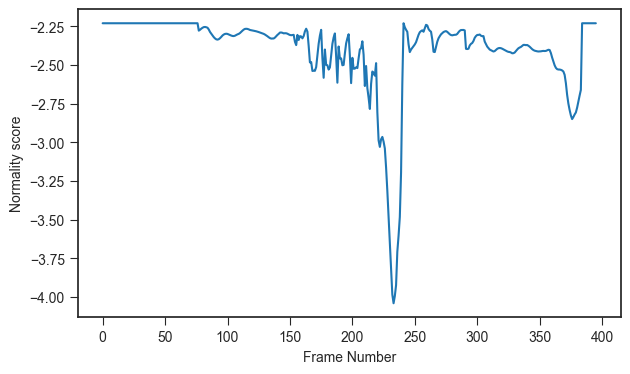

In [80]:
video_to_plot = '09_0200_alphapose_tracked_person'

print('Example plot of the abnormal score result for the video {}.mp4'.format(video_to_plot))
plt.figure(figsize=(7,4))
plt.plot(clip_scores[video_to_plot])
plt.ylabel('Normality score')
plt.xlabel('Frame Number')
plt.show()

### Show the 'abnormal poses' in red in video output

In [ ]:
# Plotting the video output...

# In the video, the colors of 
# - Normal pose (no shoplifting): Green 
# - Abnormal pose (shoplifting suspected): Red 

video_name_map = {
    'Normal_Videos313_x264':'07',
    'Normal_Videos314_x264':'08',
    'shoplifting1':'09',
    'shoplifting2':'10'
} # used to match the STG-NF model format in pose_est_video_tracking.ipynb

npzs = [os.path.join('video_output',npz) for npz in os.listdir('video_output') if npz.endswith('.npz')]
clip_cnt={clip_name: 0 for clip_name in clip_scores}
abnormal_threshold = -2.7 # pose with score lower than this will be classfied as 'abnormal' (shoplifting suspected)
for npz_path in npzs:

    video_id = video_name_map[os.path.basename(npz_path).rstrip('.npz')]

    loaded = np.load(npz_path,allow_pickle=True)
    video_path = loaded['video_path'].flatten()[0]
    track_sessions = loaded['track_sessions'].flatten()[0]
    output_path = loaded['output_path'].flatten()[0]
    output_path = output_path.rstrip('_track.mp4')+'_anomaly_det.mp4'

    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

    track_start_indices = {}
    track_start_indices_ind = {}
    tracker_ids = list(track_sessions.keys())
    for tracker_id in tracker_ids:
        track_start_indices[tracker_id] = sorted(list(track_sessions[tracker_id].keys()))
        track_start_indices_ind[tracker_id] = 0

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        for tracker_id in tracker_ids:

            start_indices_ind = track_start_indices_ind[tracker_id]
            curr_start_ind = track_start_indices[tracker_id][start_indices_ind]
            curr_end_ind = track_sessions[tracker_id][curr_start_ind][0]

            if curr_start_ind<=frame_idx<=curr_end_ind:

                curr_smoothened_kpts = track_sessions[tracker_id][curr_start_ind][1]

                clip_name = video_id+'_'+str(f'{int(100*tracker_id):04}')+'_alphapose_tracked_person'
                if clip_cnt[clip_name]<len(clip_scores[clip_name]):
                    abnormal_score = clip_scores[clip_name][clip_cnt[clip_name]]
                    coloring = (0,0,255) if abnormal_score < abnormal_threshold else (0,255,0)
                    clip_cnt[clip_name]+=1
                else:
                    coloring = (0,255,0)

                frame = draw_keypoints(frame, curr_smoothened_kpts[frame_idx-curr_start_ind], color=coloring)
                if frame_idx==curr_end_ind and start_indices_ind<len(track_start_indices[tracker_id])-1:
                    track_start_indices_ind[tracker_id]+=1
        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Saved video with normal/abnormal poses to: {output_path}")


Saved video with normal/abnormal poses to: video_output\Normal_Videos313_x26_anomaly_det.mp4
Saved video with normal/abnormal poses to: video_output\Normal_Videos314_x26_anomaly_det.mp4
Saved video with normal/abnormal poses to: video_output\shoplifting1_anomaly_det.mp4
Saved video with normal/abnormal poses to: video_output\shoplifting2_anomaly_det.mp4
